In [1]:
import pyproj
import itertools
import numpy as np
import verde as vd
import harmonica as hm
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit

from eql_source_layouts import block_reduced_points

## Read magnetic anomaly data from Rio de Janeiro

In [2]:
# Fetch magnetic anomaly data from Rio de Janeiro
data = hm.datasets.fetch_rio_magnetic()

# Reduce region of the survey to speed things up
region = [-42.60, -42.40, -22.32, -22.20]
inside = vd.inside((data.longitude.values, data.latitude.values), region)
data = data[inside]

# Project coordinates
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
data["easting"], data["northing"] = projection(
    data.longitude.values, data.latitude.values
)
coordinates = (data["easting"], data["northing"], data.altitude_m)

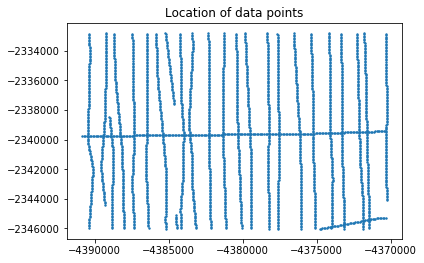

In [3]:
plt.scatter(*coordinates[:2], s=2)
plt.title("Location of data points")
plt.gca().set_aspect("equal")
plt.show()

## Generate a set of block reduced source points as an example

In [4]:
points = block_reduced_points(coordinates, spacing=1000)

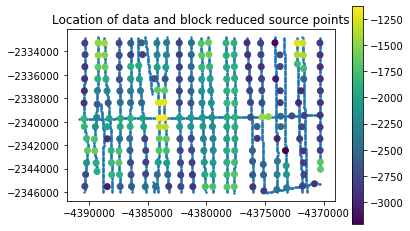

In [5]:
plt.scatter(*coordinates[:2], s=2)
tmp = plt.scatter(*points[:2], c=points[2])
plt.colorbar(tmp)
plt.title("Location of data and block reduced source points")
plt.gca().set_aspect("equal")
plt.show()

## Grid magnetic data

### Model selection

In [6]:
# Build combination of parameters
spacings = [250, 500, 1000, 1500, 2000]
depth_factors = [0.1, 0.5, 0.75, 1]
static_shifts = [0, -100, -200, -300, -400, -500, -600, -700, -800, -900, -100]

# Use itertools to create a list with all combinations of parameters to test
parameter_sets = [
    dict(spacing=combo[0], depth_factor=combo[1], static_shift=combo[2])
    for combo in itertools.product(spacings, depth_factors, static_shifts)
]
print("Number of combinations:", len(parameter_sets))

Number of combinations: 220


In [7]:
scores = []
gridder = hm.EQLHarmonic()

for params in parameter_sets:
    points = block_reduced_points(coordinates, **params)
    gridder.set_params(points=points)
    shuffle = ShuffleSplit(n_splits=10, test_size=0.3, random_state=1)
    score = np.mean(
        vd.cross_val_score(
            gridder, coordinates, data.total_field_anomaly_nt, cv=shuffle
        )
    )
    scores.append(score)
print("Scores: {}".format(scores))

Scores: [-72.59885727996911, -3.765911899094283, -2.5165137051563575, 0.28476284107455657, 0.3354520848714226, 0.23460588334202398, 0.49778484928275085, 0.6888579996829631, 0.797969692910173, 0.8553688943213338, -3.765911899094283, -3.9950356581105297, -3.1550593880969786, -0.039518341172284185, 0.06495785392407774, 0.010835047100674445, 0.38817267783520226, 0.6158678214099986, 0.7046160029685045, 0.7208878355035285, 0.7342464826539503, -3.1550593880969786, -6.201695006228282, -0.7244254459011596, -0.09964664400618499, -0.20211281814179288, 0.1769392332004646, 0.5199973482545109, 0.6745673474135685, 0.7294457121078791, 0.7621140653149104, 0.8353667847090751, -0.7244254459011596, -2.936719016841824, -0.4829827150717033, -0.44063416274006206, -0.1421892731553797, 0.371720492932291, 0.6313687639132942, 0.746297066977022, 0.8212646672124404, 0.892624333136659, 0.9426156714075271, -0.4829827150717033, 0.2327253756846801, 0.9004201766912316, 0.9309963493787562, 0.9424341750155296, 0.94878957

In [8]:
best = np.argmax(scores)
print("Best score:", scores[best])
print("Best parameters:", parameter_sets[best])

params = parameter_sets[best]
points = block_reduced_points(coordinates, **params)
gridder.set_params(points=points)
gridder.fit(coordinates, data.total_field_anomaly_nt)

Best score: 0.9611548930052253
Best parameters: {'spacing': 500, 'depth_factor': 0.5, 'static_shift': -900}


EQLHarmonic(damping=None, depth_factor=3, k_nearest=1,
            points=(array([-4390393.95982238, -4388865.19061935, -4388044.21929369,
       -4387345.90407318, -4386380.21915791, -4385197.56693059,
       -4384480.3894687 , -4384159.52522052, -4383190.64506218,
       -4382182.49433571, -4381153.93528251, -4380085.28108233,
       -4379463.2394062 , -4378247.5009522 , -4377640.40476787,
       -4376037.7326846...
        -963.99382643,  -930.93821426,  -923.21504172,  -935.44698144,
        -941.80413958,  -914.41271166,  -967.45049647, -1012.38241239,
       -1026.60195836,  -962.04392971,  -923.13761397,  -989.08720335,
        -974.3592883 , -1018.08816246,  -976.41136522,  -986.46183555,
        -966.11249158, -1002.80763514,  -964.01893892,  -898.62207501,
        -963.61651164,  -956.3367345 , -1008.79382643, -1015.95795676,
        -982.95504172,  -993.27723837,  -979.14413958,  -973.85049647])))

### Interpolate data into the regular grid at 200m above the sea level

In [9]:
region = vd.get_region(coordinates)
grid = gridder.grid(
    region=region, spacing=250, data_names=["magnetic_anomaly"], extra_coords=200
)

### Plot best result

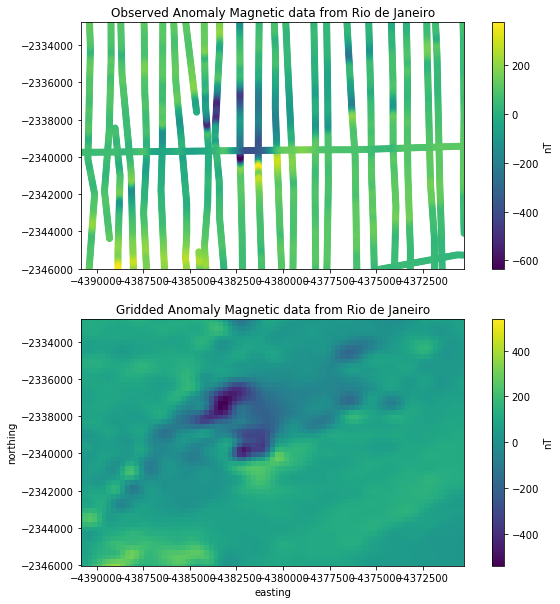

In [10]:
# Plot original magnetic anomaly
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
tmp = ax1.scatter(data.easting, data.northing, c=data.total_field_anomaly_nt)
plt.colorbar(tmp, ax=ax1, label="nT")
ax1.set_xlim(*region[:2])
ax1.set_ylim(*region[2:])
ax1.set_aspect("equal")
ax1.set_title("Observed Anomaly Magnetic data from Rio de Janeiro")

# Plot gridded magnetic anomaly
tmp = grid.magnetic_anomaly.plot.pcolormesh(ax=ax2, add_colorbar=False, cmap="viridis")
plt.colorbar(tmp, ax=ax2, label="nT")
ax2.set_xlim(*region[:2])
ax2.set_ylim(*region[2:])
ax2.set_aspect("equal")
ax2.set_title("Gridded Anomaly Magnetic data from Rio de Janeiro")
plt.show()

## Plot all results

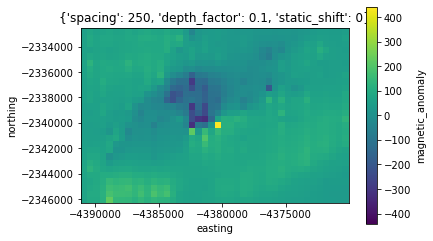

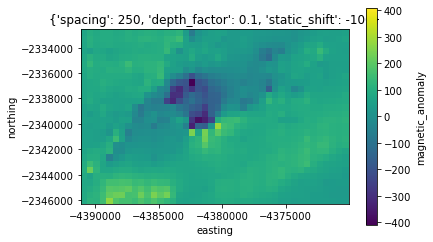

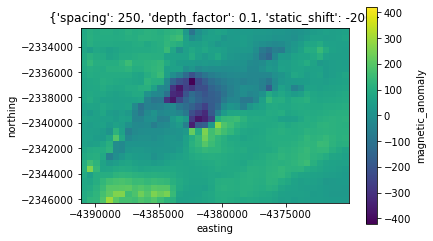

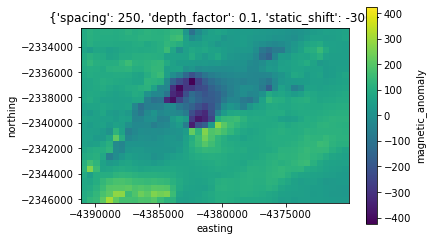

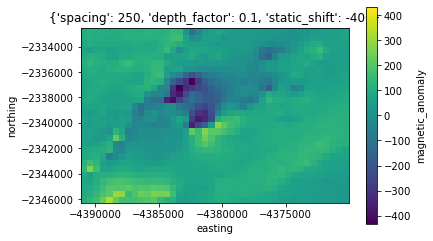

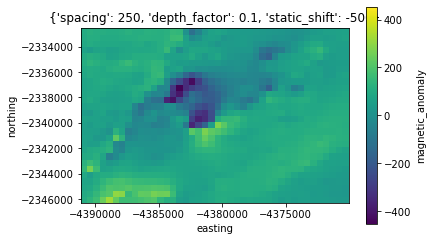

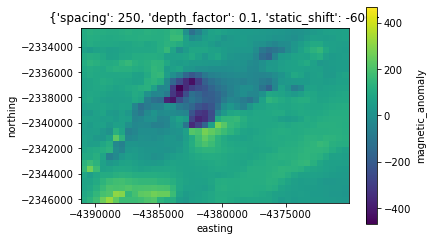

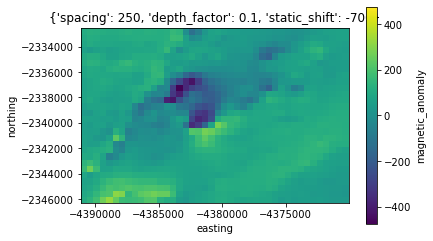

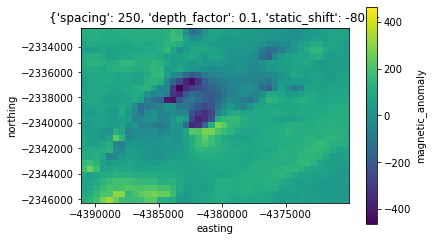

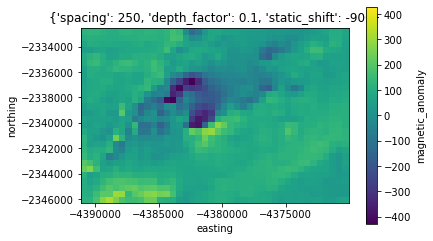

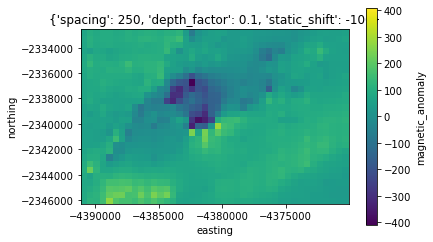

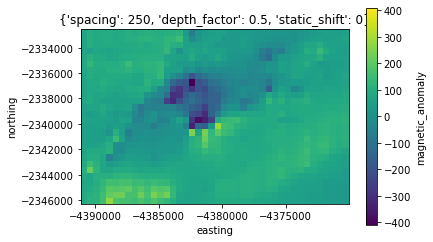

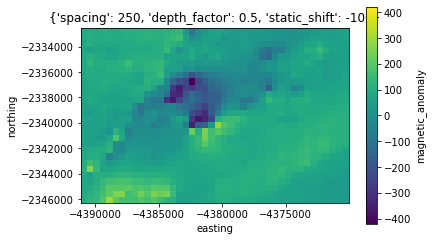

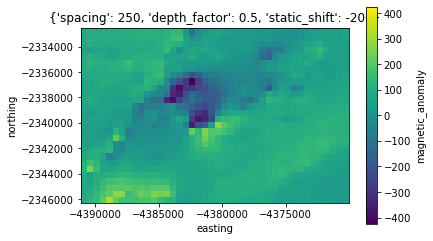

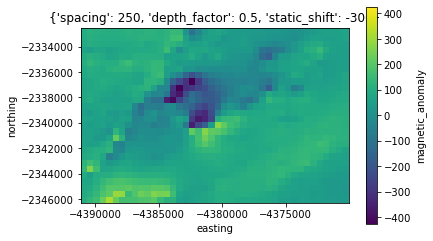

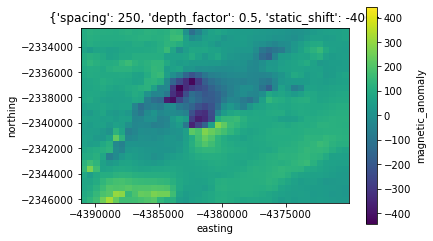

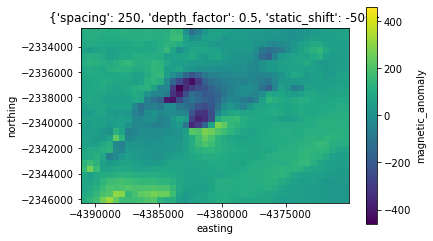

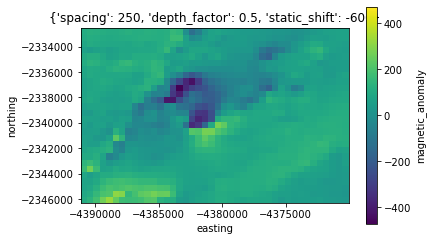

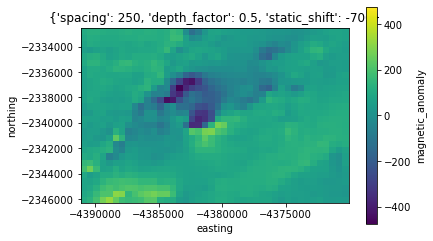

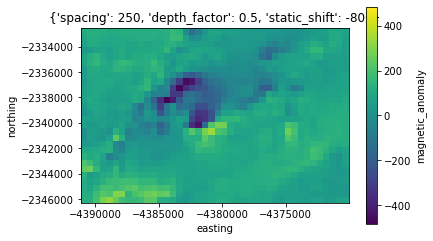

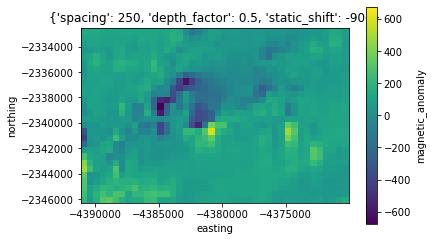

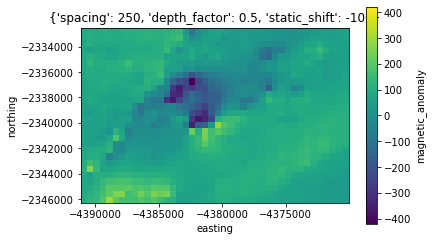

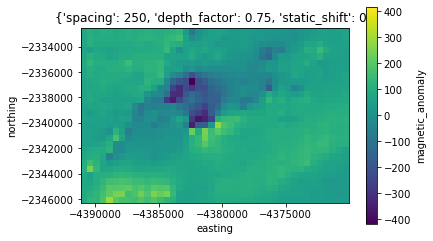

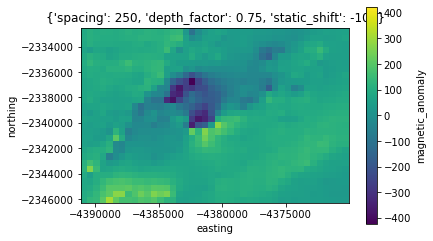

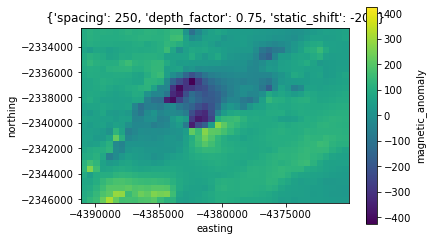

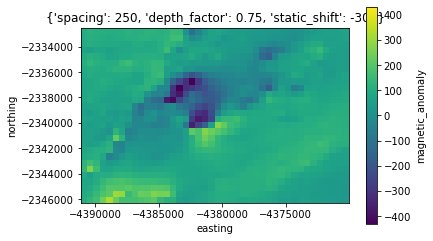

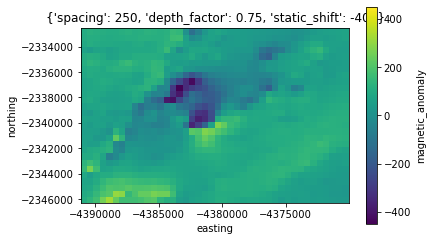

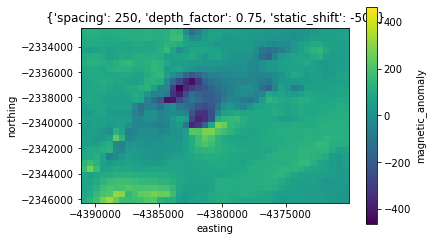

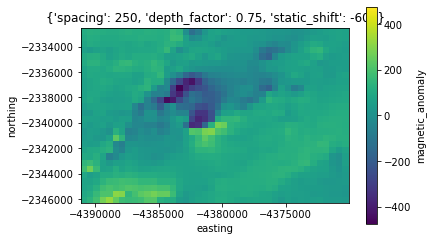

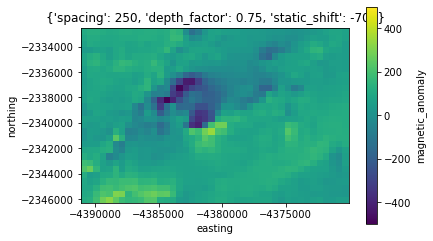

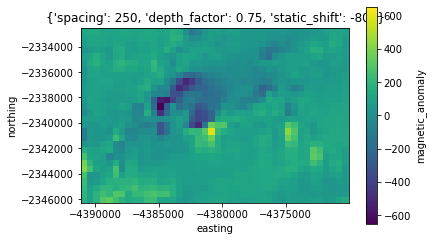

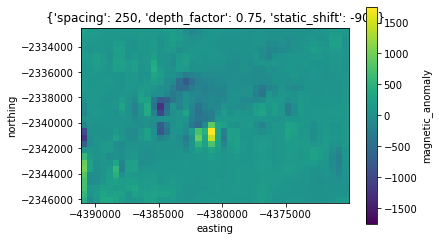

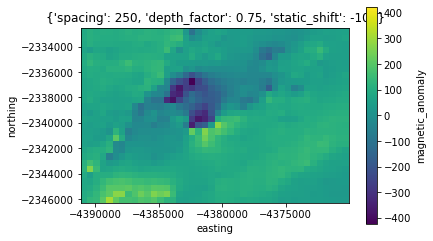

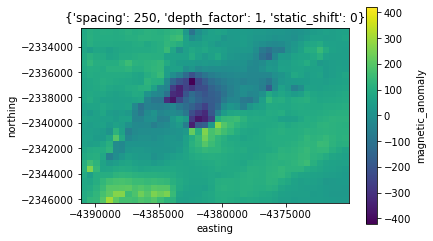

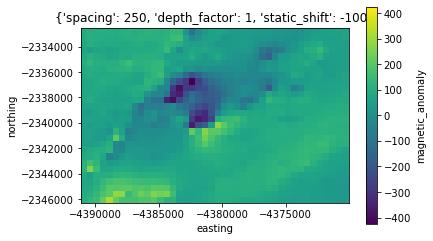

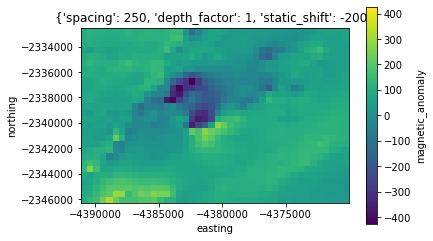

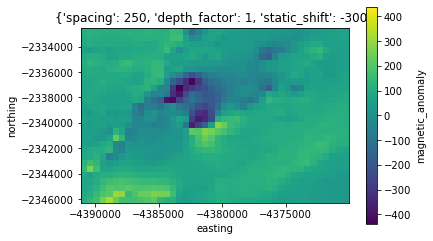

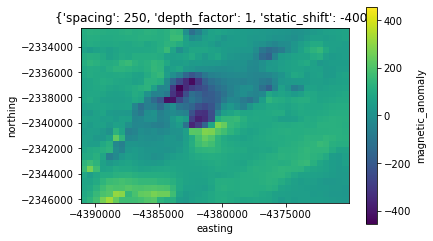

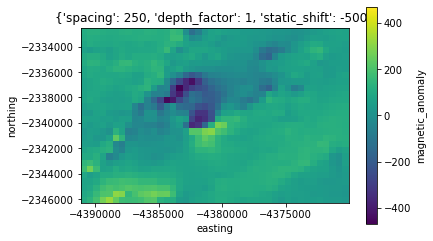

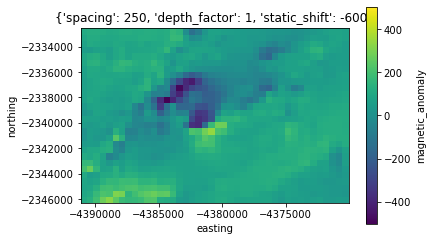

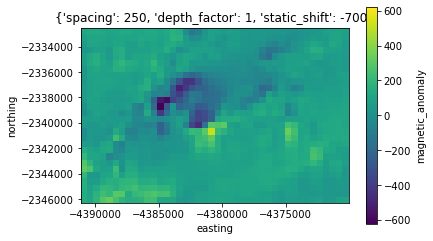

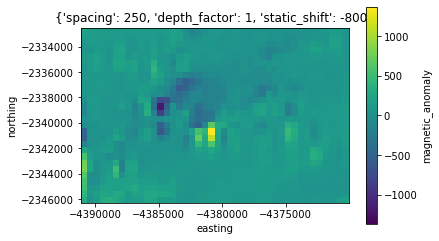

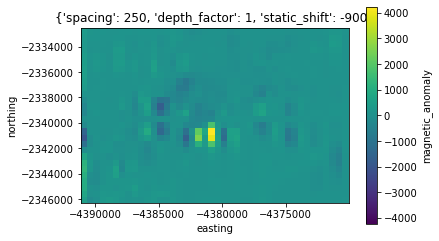

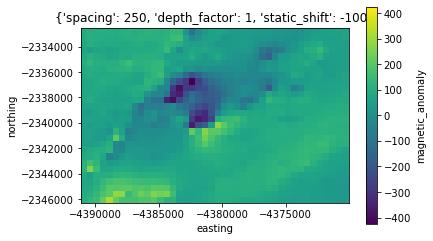

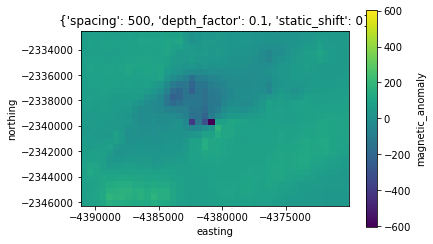

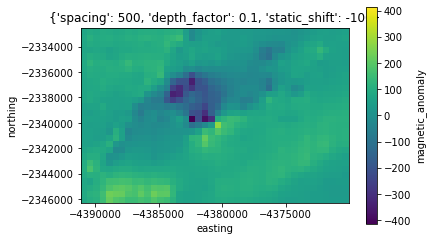

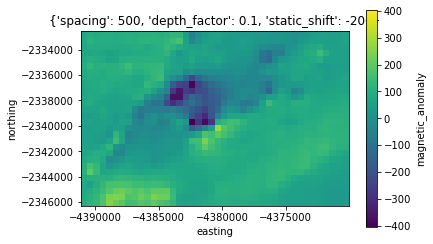

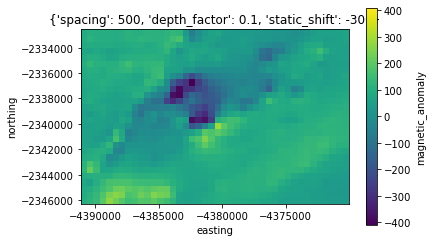

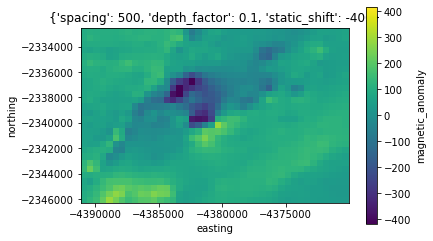

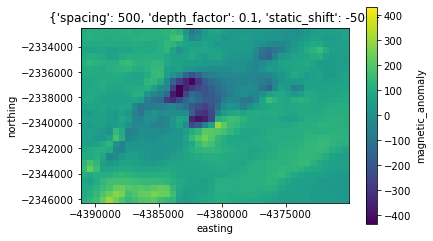

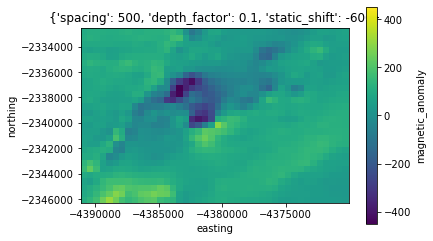

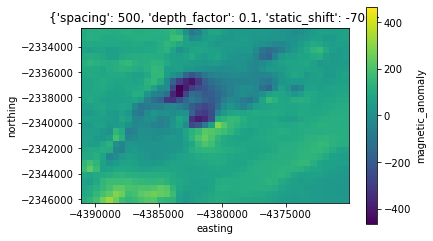

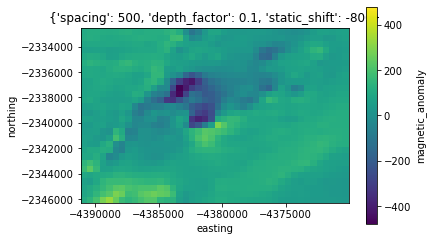

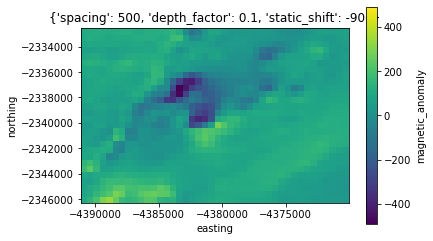

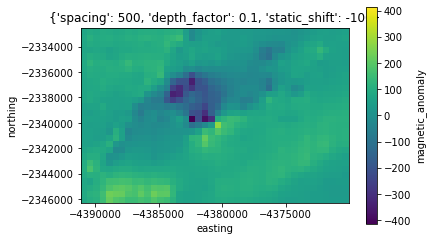

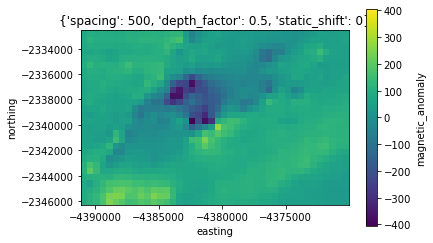

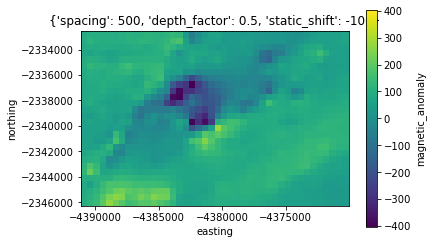

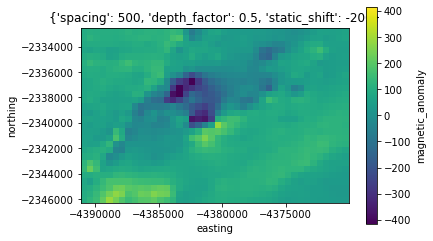

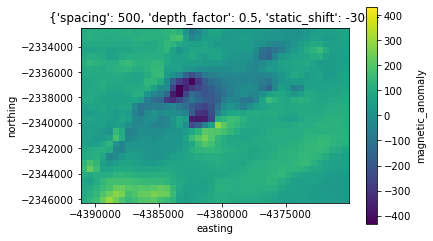

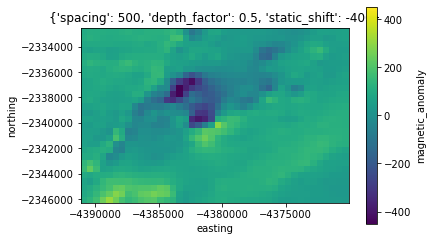

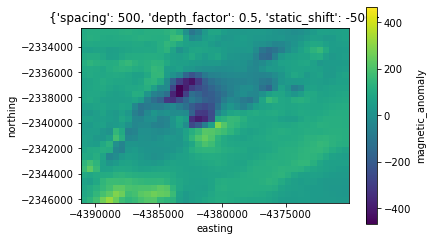

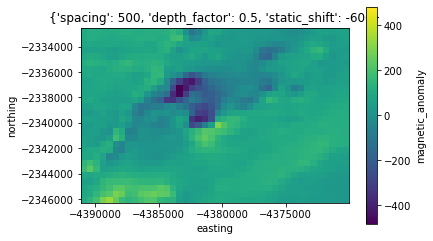

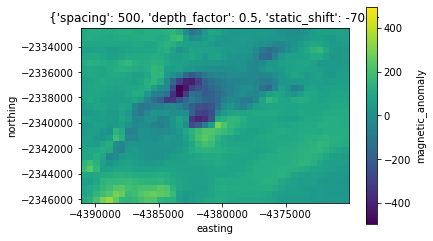

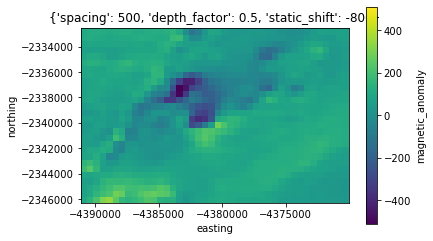

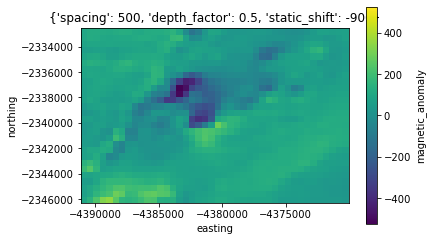

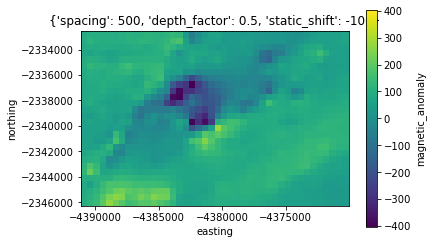

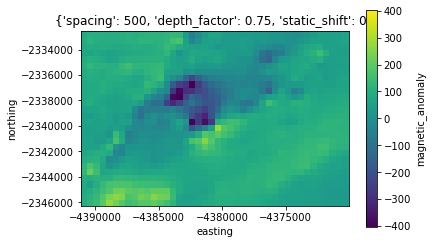

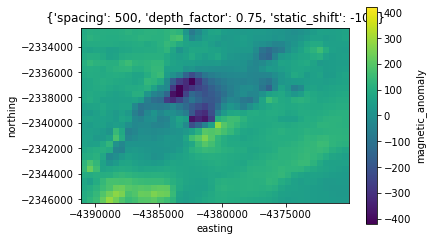

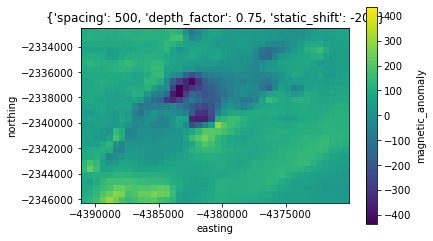

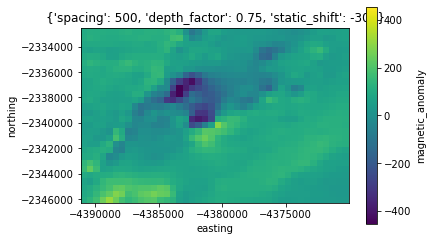

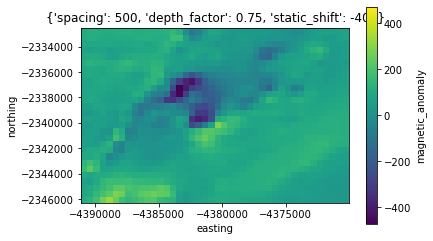

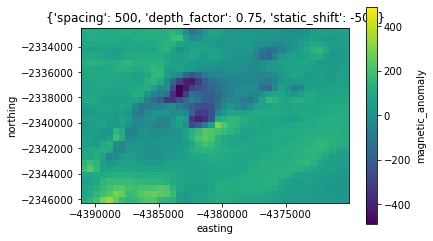

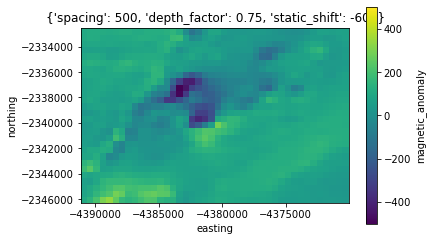

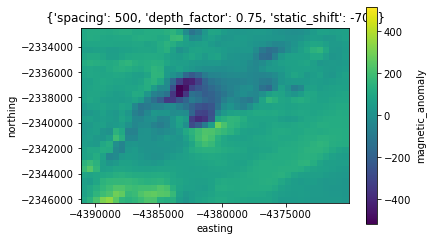

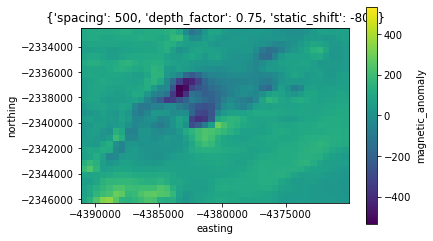

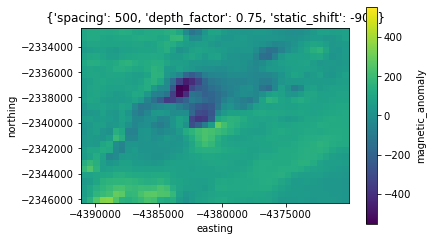

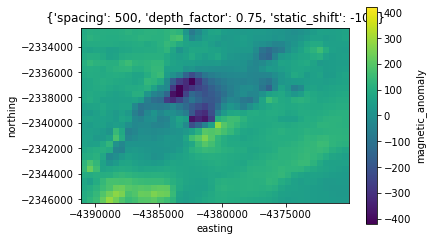

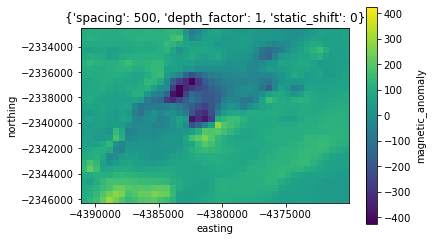

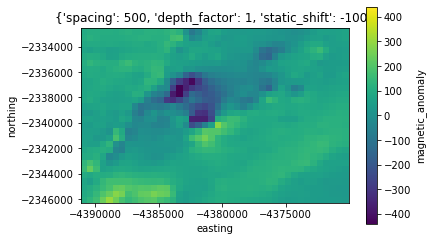

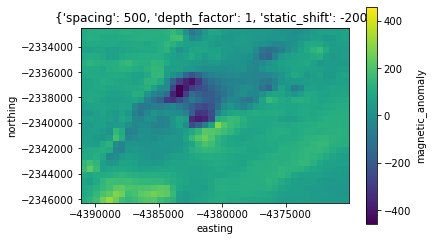

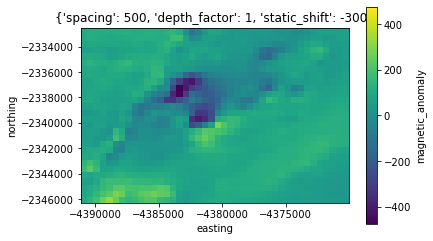

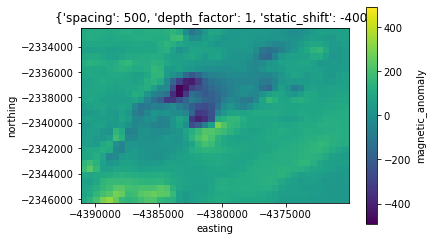

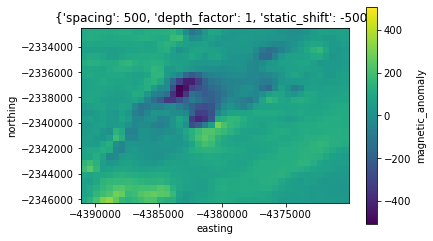

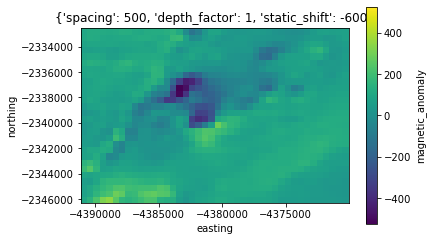

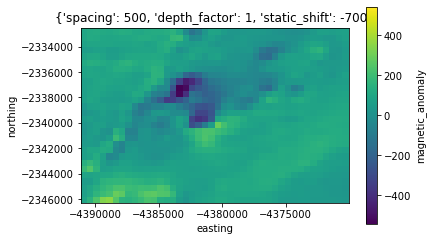

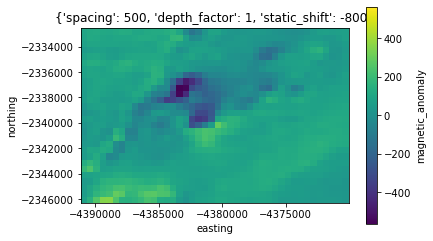

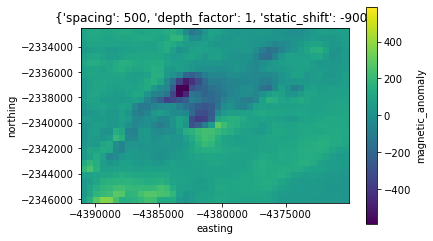

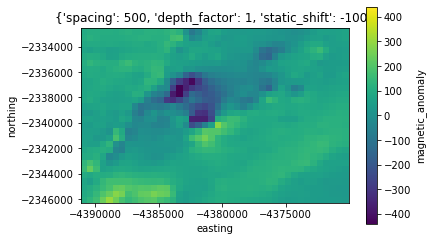

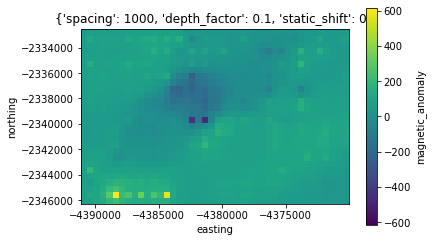

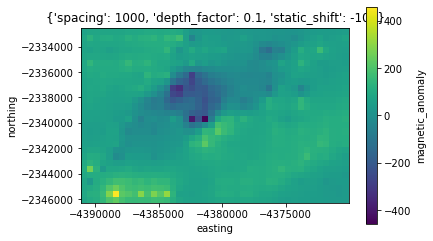

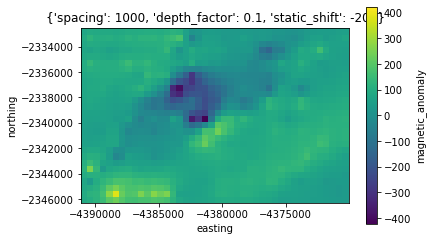

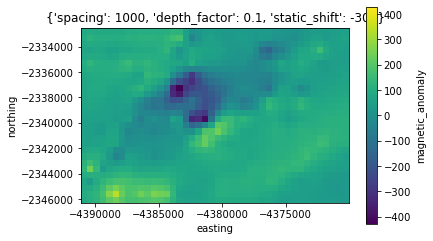

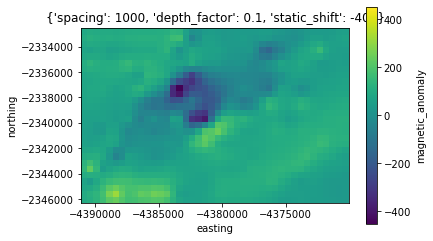

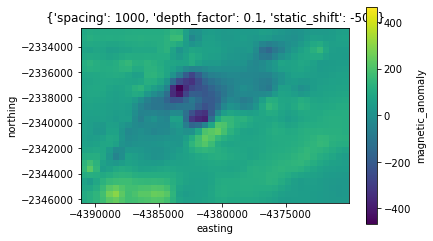

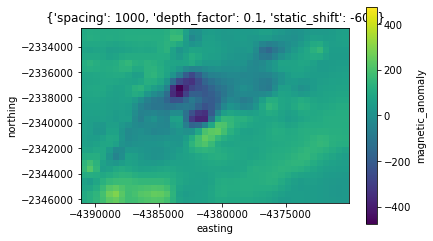

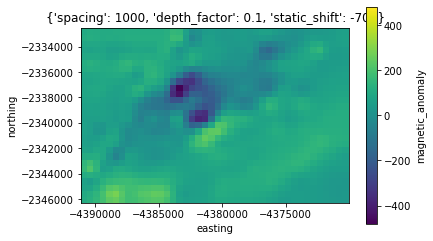

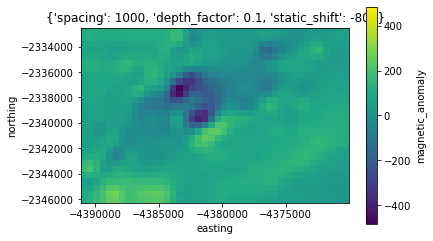

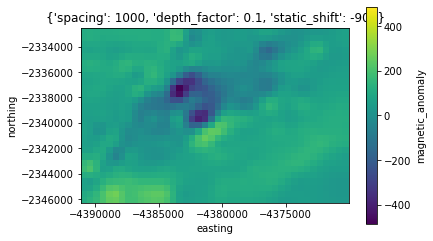

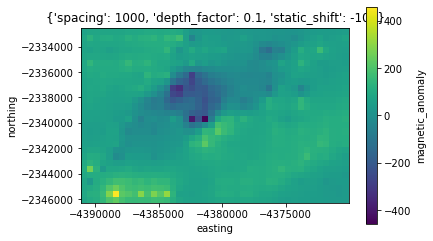

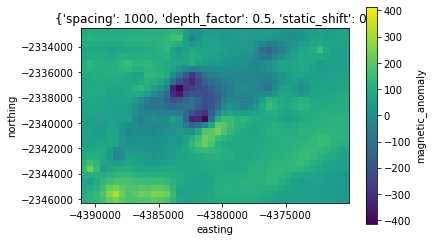

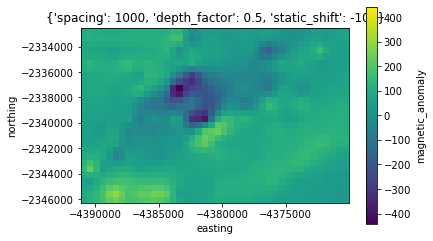

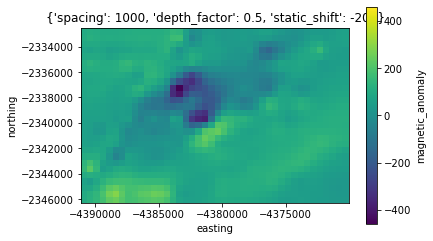

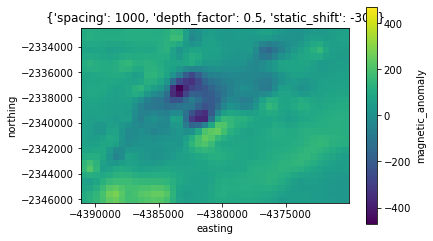

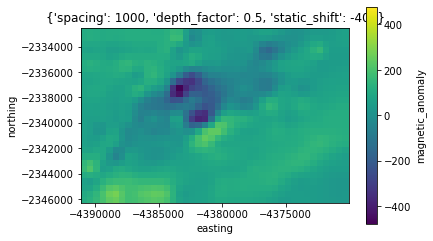

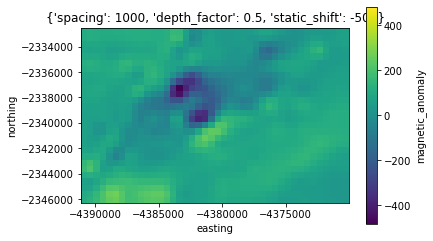

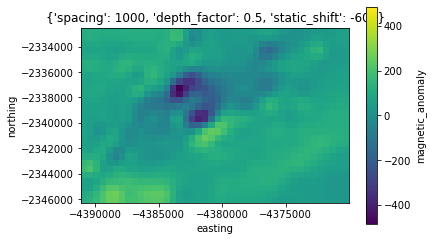

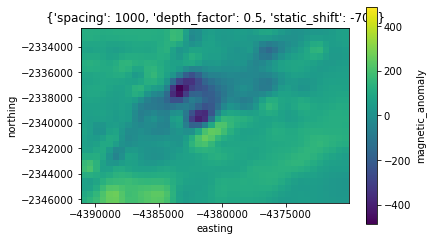

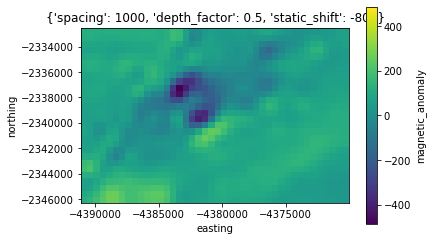

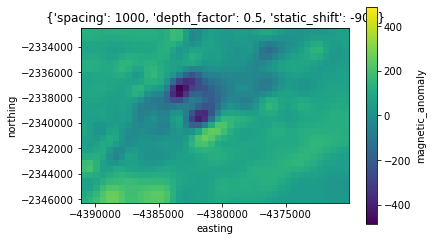

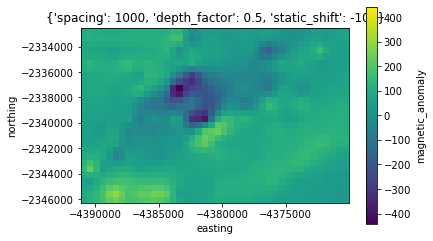

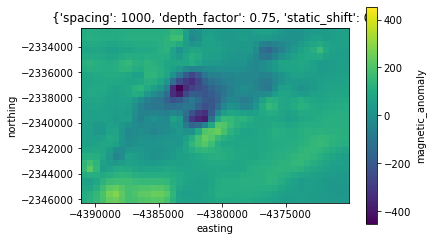

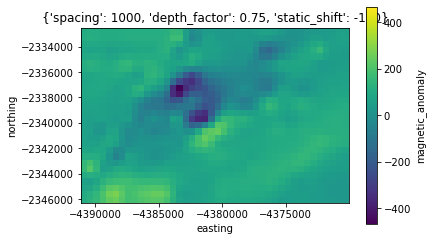

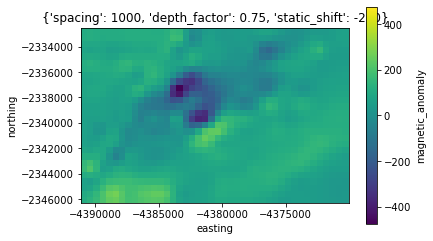

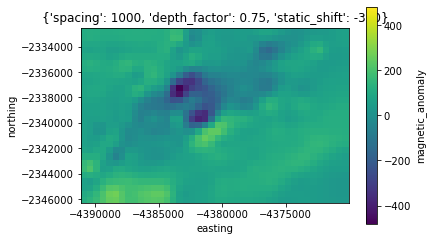

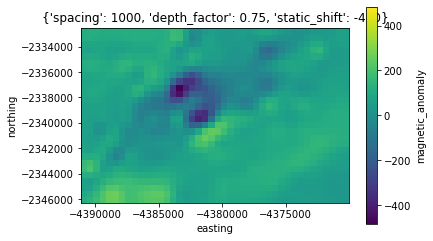

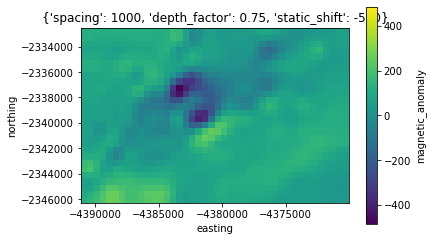

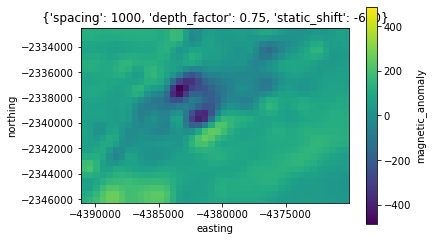

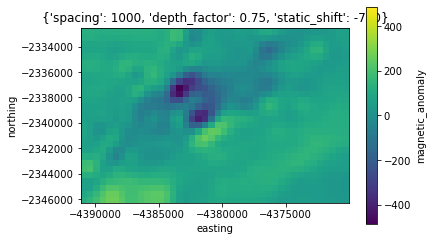

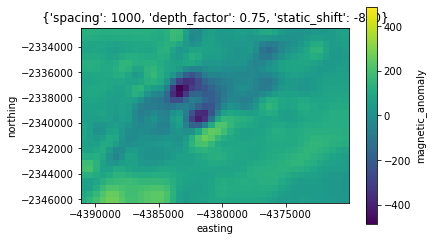

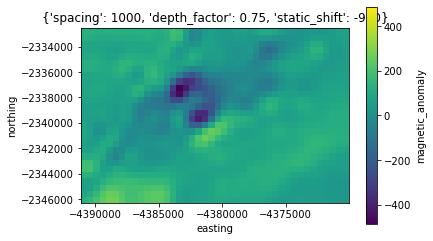

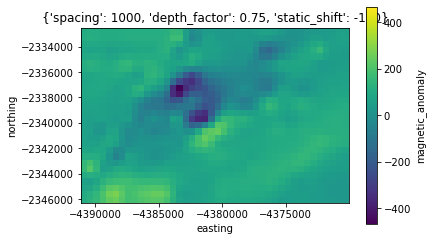

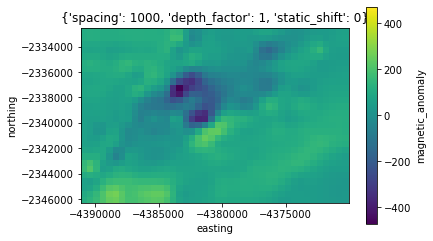

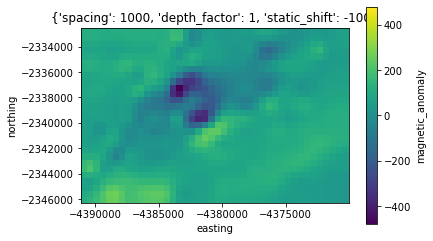

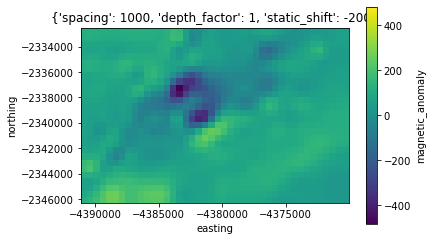

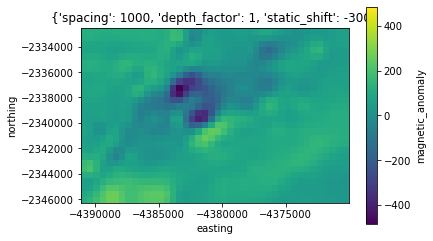

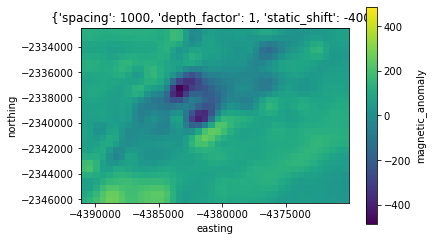

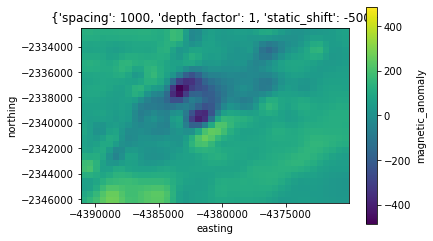

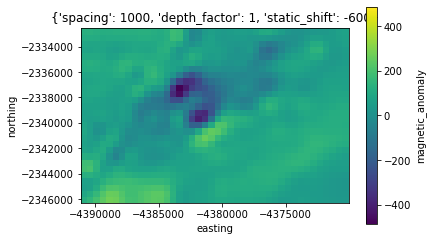

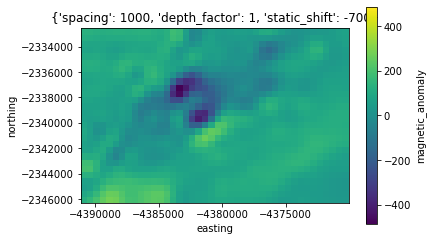

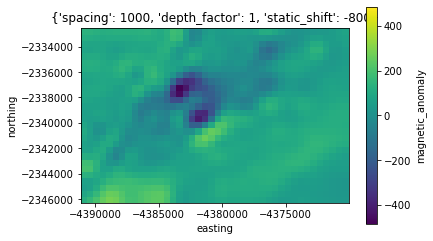

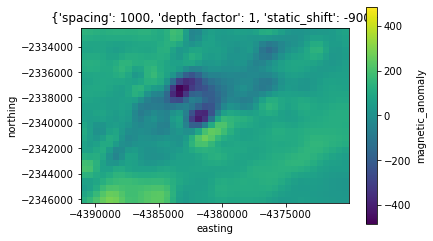

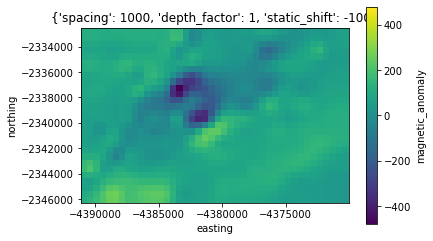

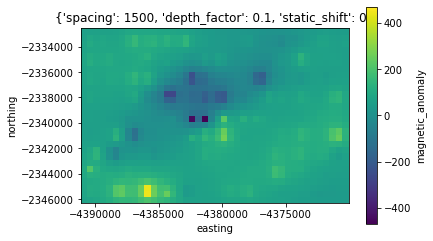

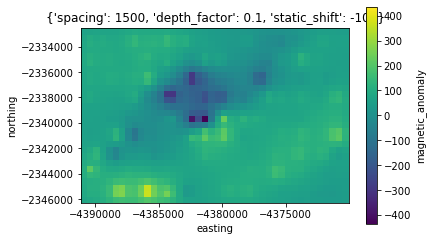

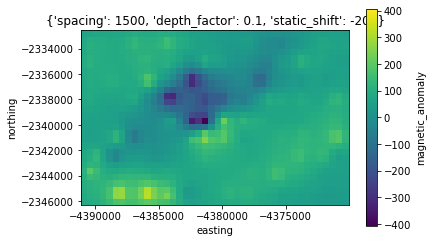

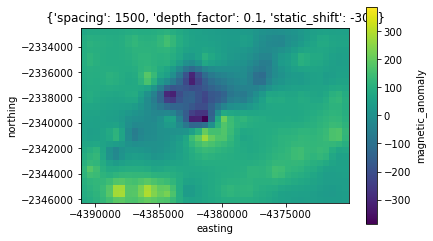

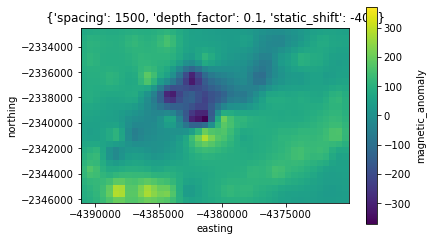

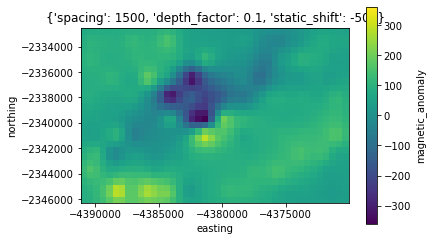

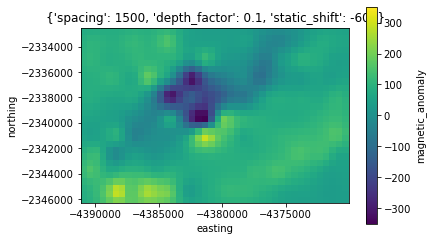

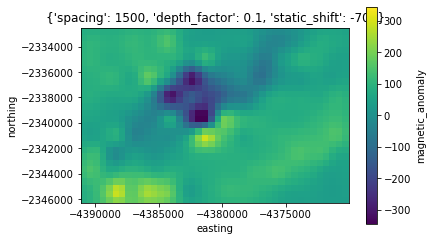

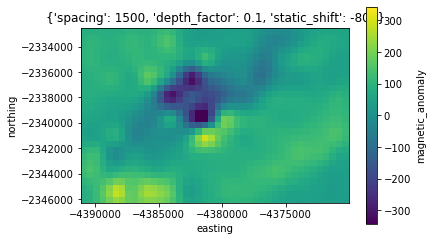

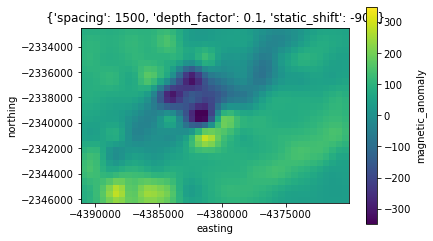

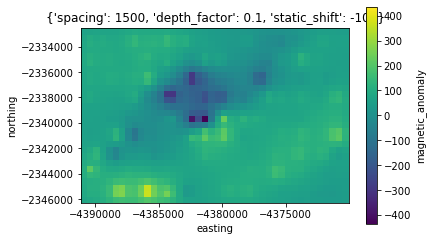

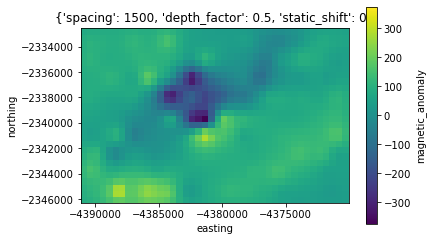

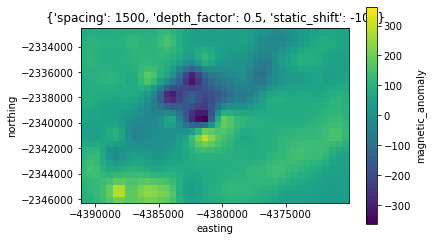

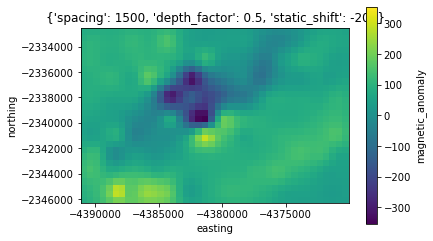

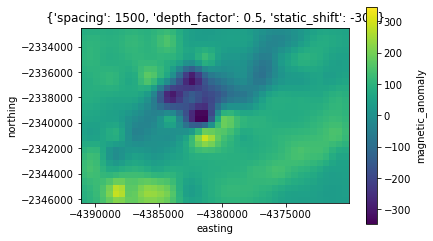

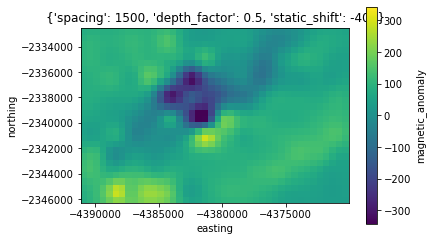

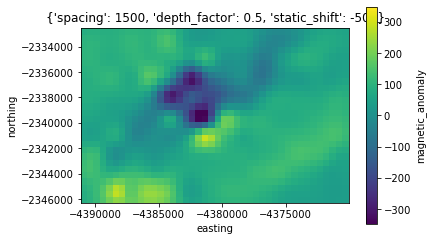

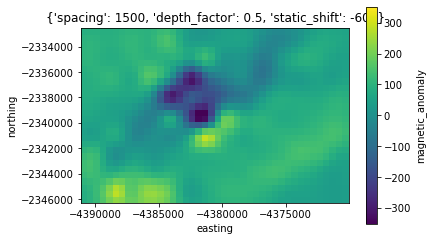

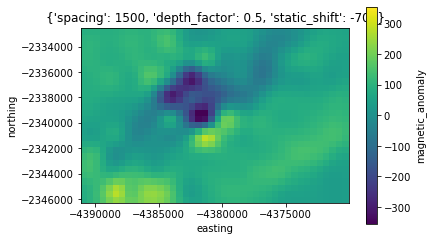

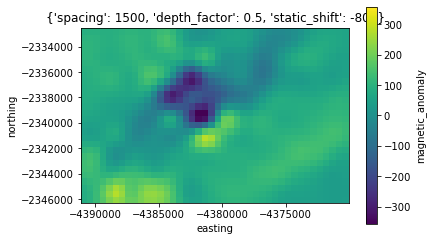

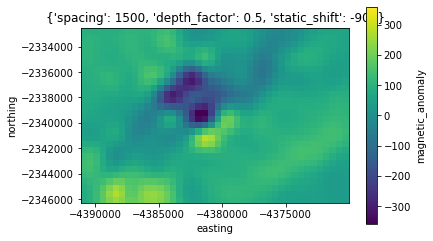

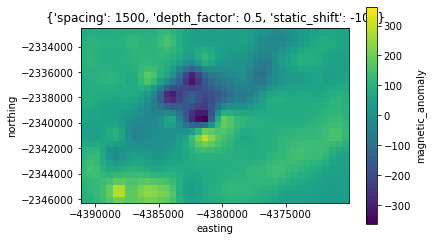

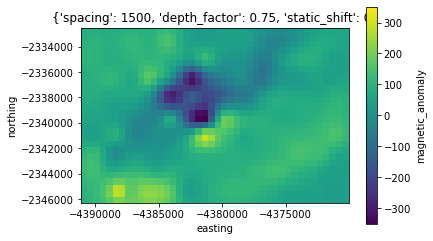

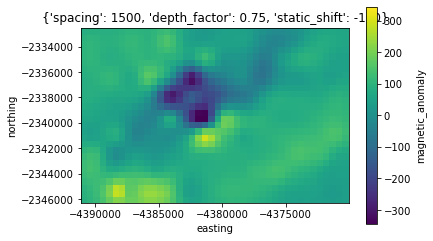

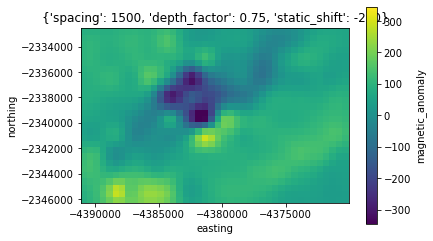

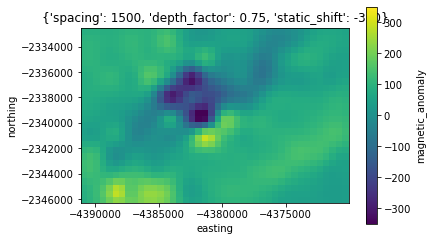

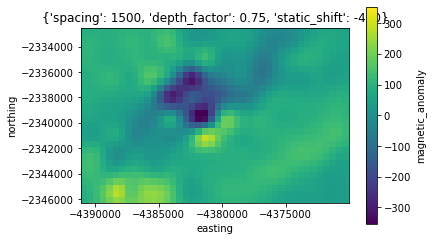

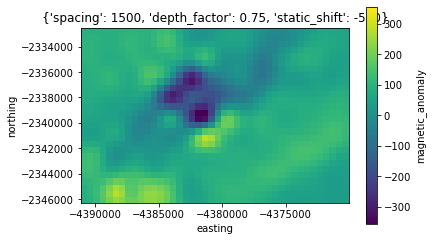

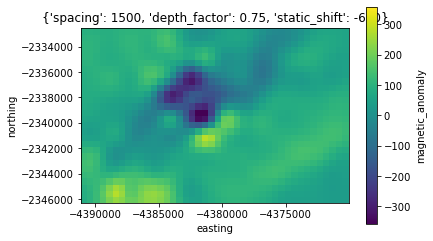

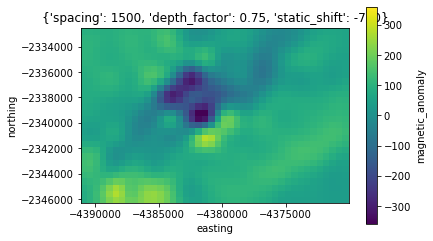

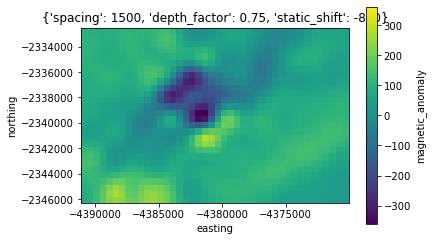

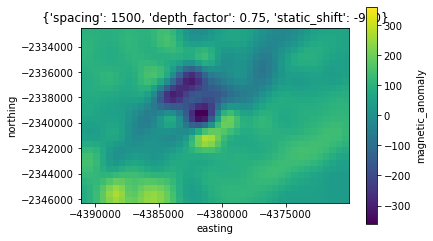

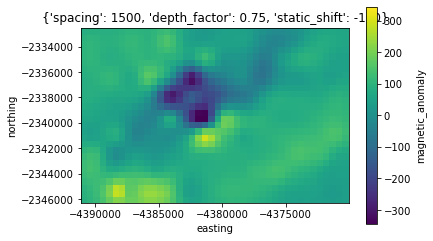

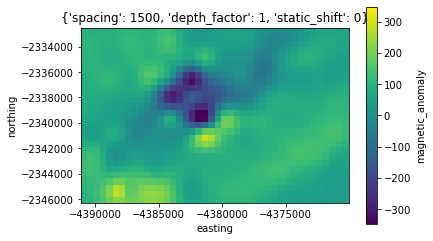

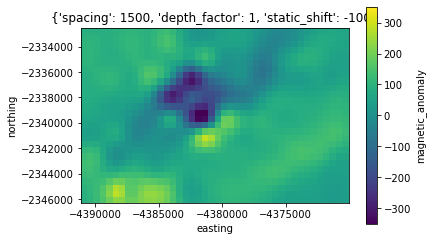

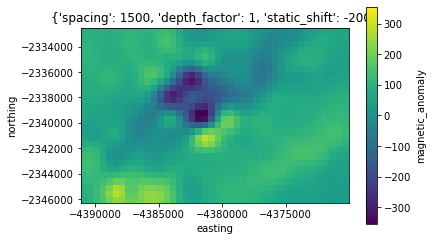

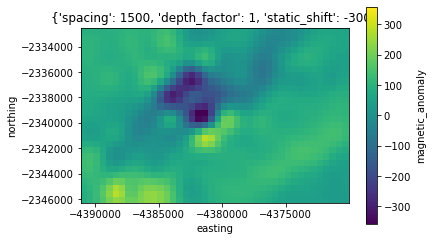

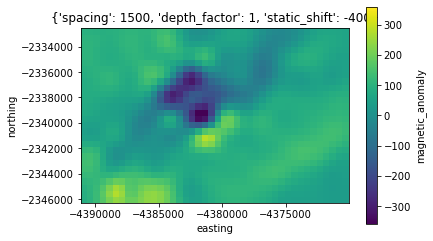

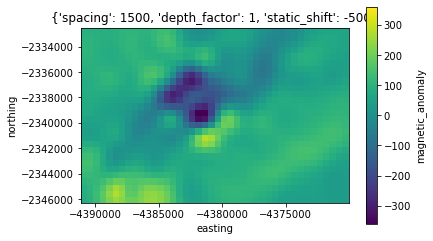

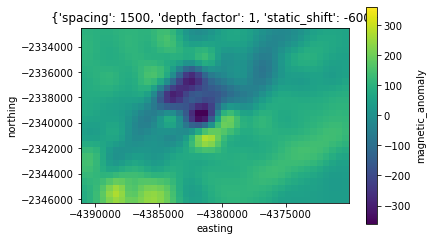

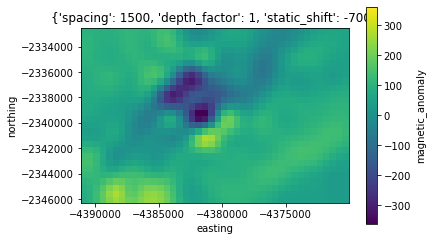

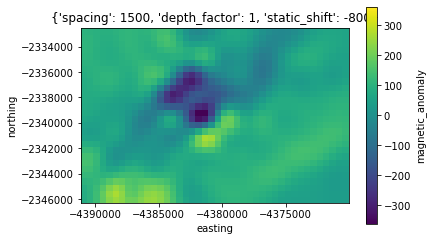

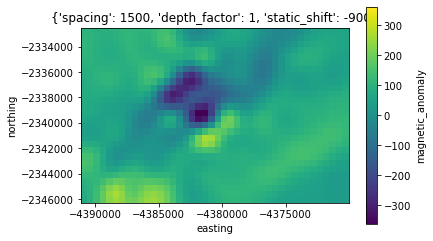

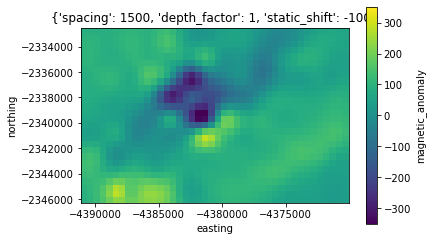

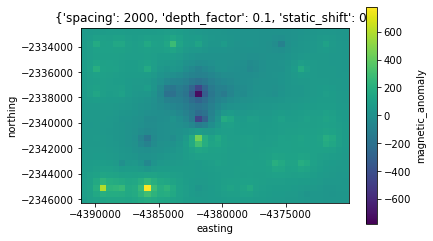

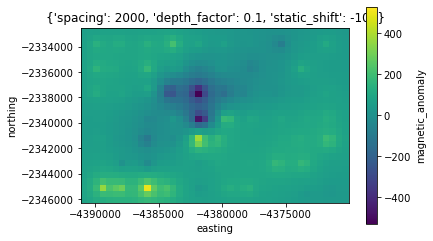

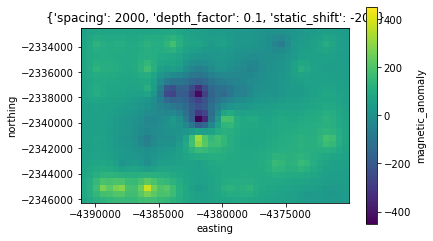

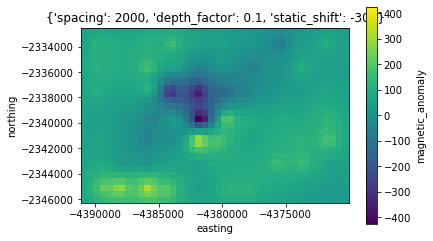

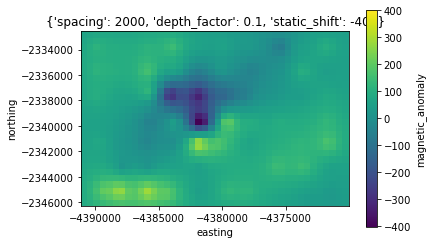

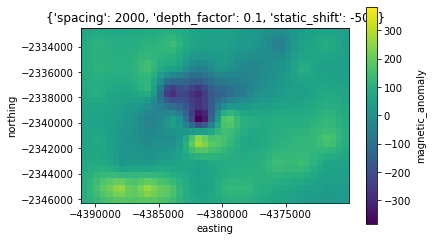

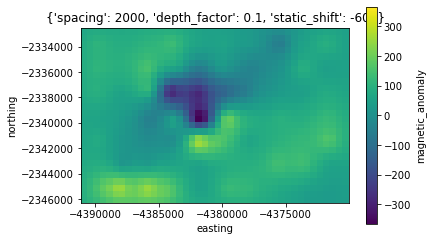

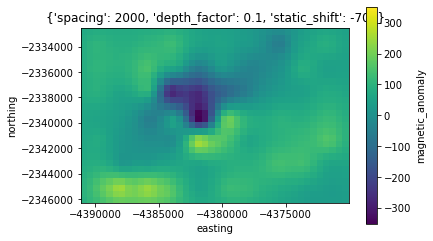

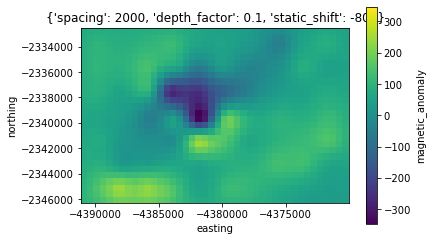

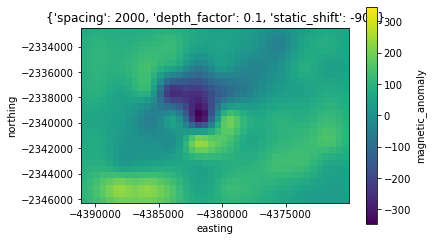

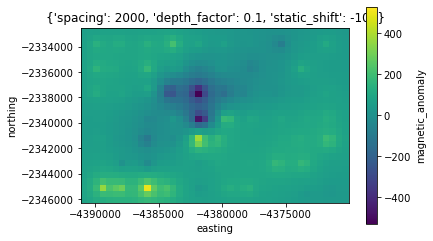

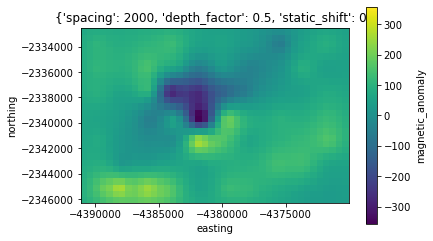

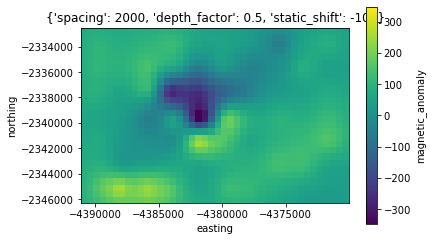

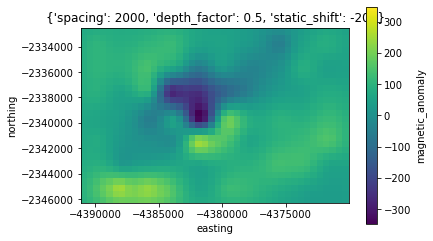

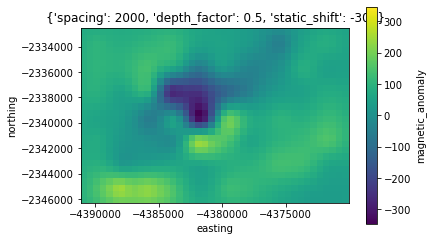

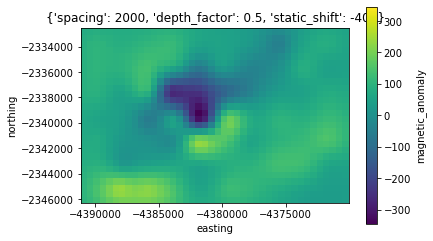

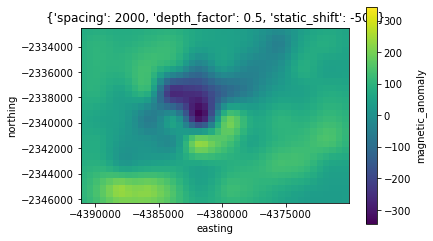

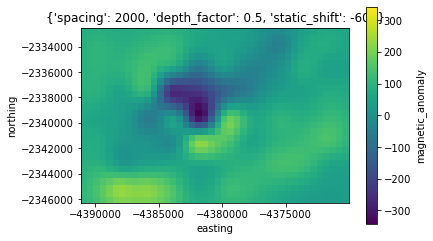

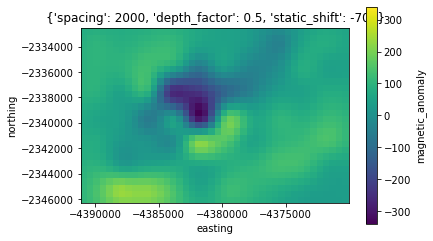

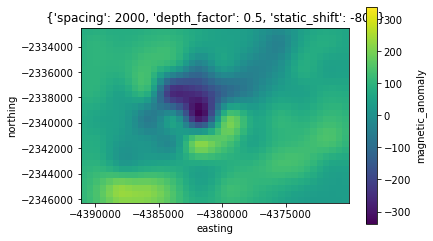

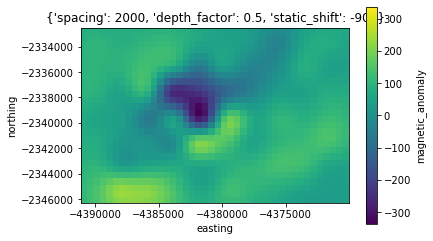

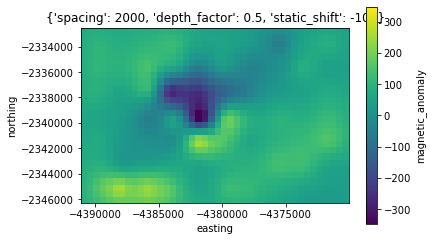

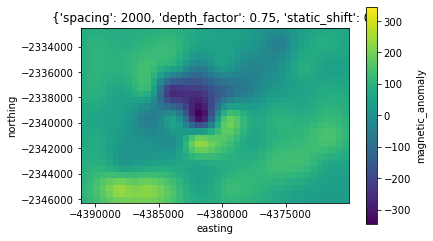

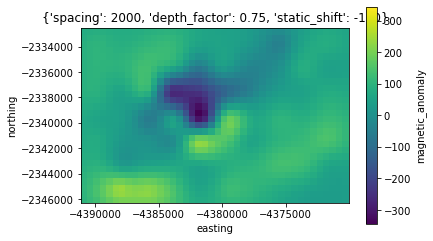

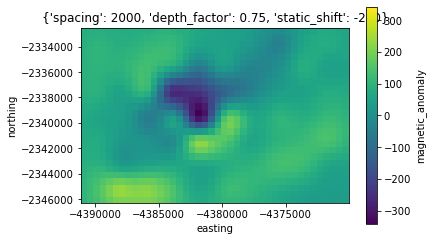

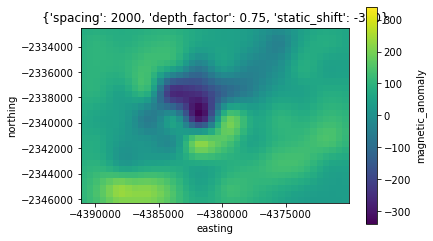

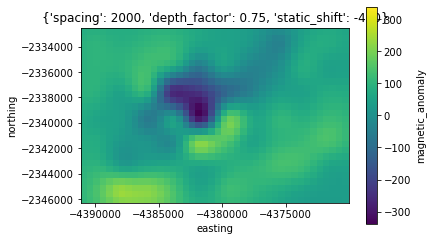

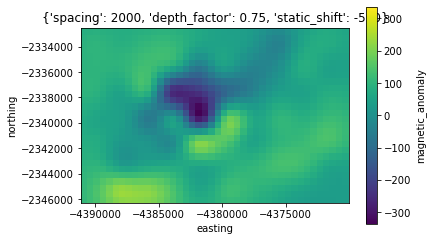

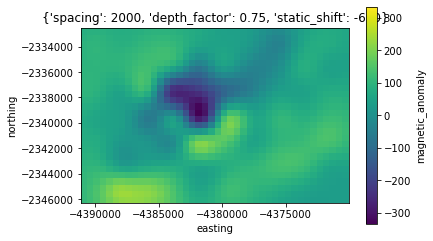

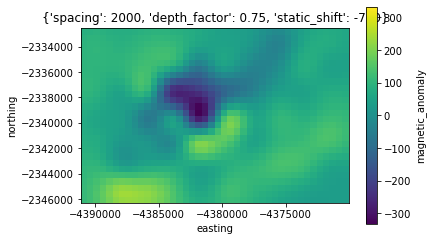

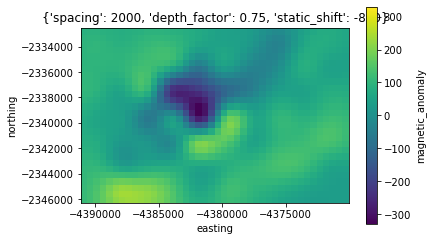

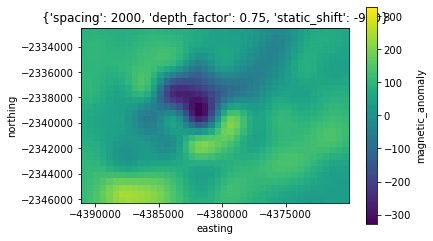

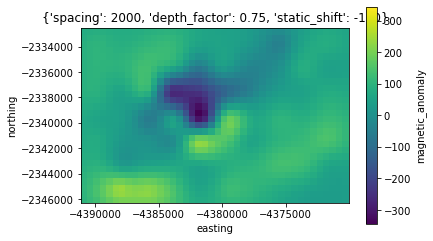

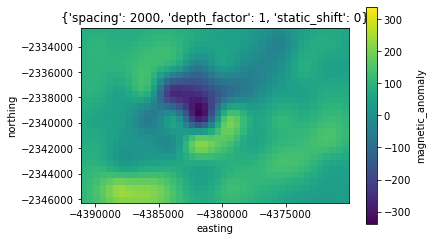

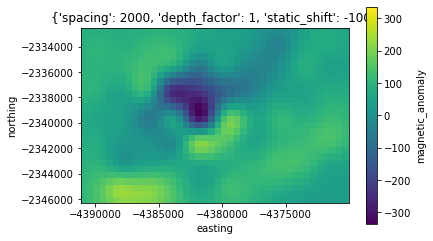

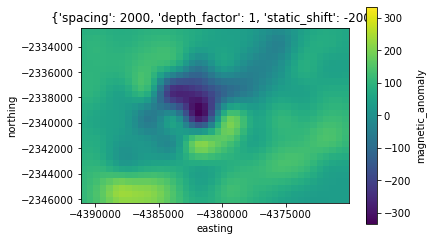

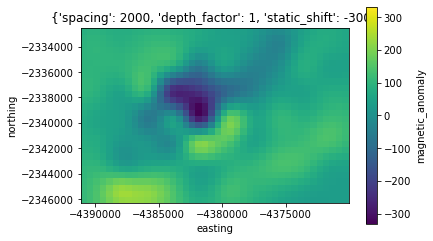

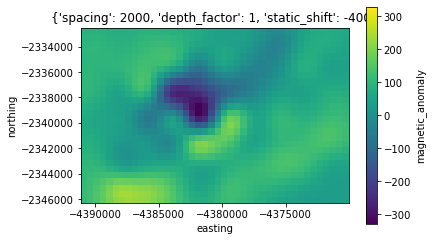

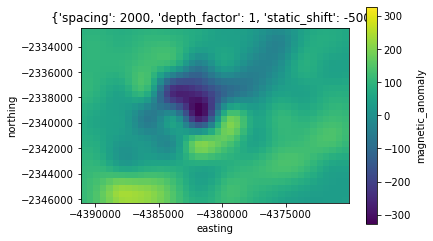

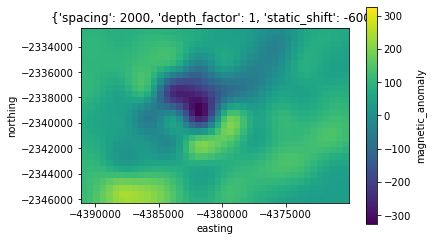

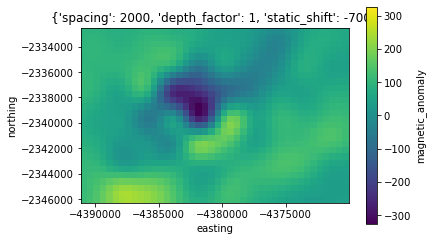

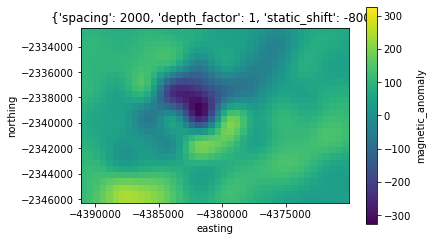

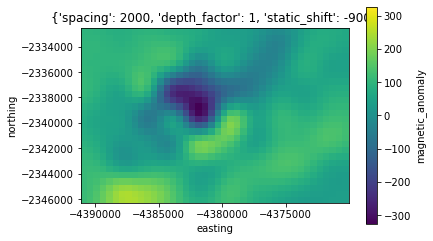

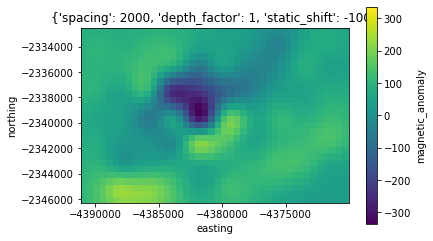

In [11]:
region = vd.get_region(coordinates)

for params in parameter_sets:
    points = block_reduced_points(coordinates, **params)
    gridder.set_params(points=points)
    gridder.fit(coordinates, data.total_field_anomaly_nt)
    grid = gridder.grid(
        region=region, spacing=500, data_names=["magnetic_anomaly"], extra_coords=200
    )

    tmp = grid.magnetic_anomaly.plot.pcolormesh(cmap="viridis")
    plt.gca().set_aspect("equal")
    plt.title(str(params))
    plt.show()